# LSTM Temperature Prediction
- Using LSTM model with TFLite EI_SDK
- Predicting temperature, 1 hour in the future
- By Pietro D'Agostino @ September, 2024

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
import logging
import pandas as pd  # Importa la libreria pandas

# Configura il logger
logging.basicConfig(level=logging.ERROR)

file_path = '../dati/50_sensors/0_report_total.txt'

# Dizionario per conservare i dati delle temperature per ciascun nodo
temperatures = {}

try:
    with open(file_path, 'r') as file:
        logging.info('File aperto con successo.')

        for line in file:
            decoded_data = line.strip()

            if not decoded_data:
                continue

            parts = decoded_data.split(';')
            if len(parts) == 3:
                try:
                    node_name = parts[0]
                    temperature_label = parts[1]
                    temperatura_float = float(parts[2])

                    if temperatura_float == 0.0:
                        continue

                    # Aggiungi la temperatura al dizionario
                    if node_name not in temperatures:
                        temperatures[node_name] = []
                    
                    temperatures[node_name].append(temperatura_float)

                except ValueError as e:
                    logging.error(f"Errore nella conversione dei dati: {e}")
                    continue
            else:
                logging.error("Formato dei dati ricevuti non valido.")
                continue

except FileNotFoundError as e:
    logging.error(f"File non trovato: {e}")
except Exception as e:
    logging.error(f"Errore imprevisto: {e}")

# Crea un DataFrame a partire dal dizionario delle temperature
df = pd.DataFrame.from_dict(temperatures, orient='index').transpose()

# Stampa le temperature di NODE_01
node_to_print = 'NODE_01'
if node_to_print in temperatures:
    x = list(range(len(temperatures[node_to_print])))
else:
    print(f"Nessun dato disponibile per {node_to_print}.")


ERROR:root:Formato dei dati ricevuti non valido.


## Load the dataset

In [7]:
df.shape

(43434, 49)

In [8]:
df.head()

,NODE_15,NODE_17,NODE_08,NODE_13,NODE_10,NODE_35,NODE_26,NODE_22,NODE_19,NODE_37,...,NODE_25,NODE_12,NODE_24,NODE_27,NODE_06,NODE_33,NODE_44,NODE_41,NODE_36,NODE_29
0,29.51,29.42,28.62,28.67,28.51,28.93,29.48,28.66,28.75,29.34,...,29.01,29.06,28.68,29.3,28.82,28.96,28.74,28.85,28.43,28.78
1,29.51,29.43,28.62,28.67,28.53,28.96,29.48,28.66,28.75,29.34,...,29.01,29.08,28.67,29.3,28.82,28.96,28.75,28.85,28.43,28.78
2,29.54,29.43,28.60,28.66,28.54,28.96,29.48,28.64,28.76,29.35,...,29.01,29.06,28.67,29.3,28.82,28.96,28.75,28.85,28.43,28.78
3,29.53,29.43,28.62,28.66,28.53,28.96,29.48,28.67,28.76,29.37,...,29.01,29.06,28.66,29.3,28.82,28.96,28.75,28.85,28.43,28.78
4,29.54,29.43,28.62,28.66,28.54,28.96,29.48,28.65,28.76,29.37,...,29.01,29.06,28.66,29.3,28.82,28.96,28.75,28.85,28.43,28.78


In [9]:
df

,NODE_15,NODE_17,NODE_08,NODE_13,NODE_10,NODE_35,NODE_26,NODE_22,NODE_19,NODE_37,...,NODE_25,NODE_12,NODE_24,NODE_27,NODE_06,NODE_33,NODE_44,NODE_41,NODE_36,NODE_29
0,29.51,29.42,28.62,28.67,28.51,28.93,29.48,28.66,28.75,29.34,...,29.01,29.06,28.68,29.3,28.82,28.96,28.74,28.85,28.43,28.78
1,29.51,29.43,28.62,28.67,28.53,28.96,29.48,28.66,28.75,29.34,...,29.01,29.08,28.67,29.3,28.82,28.96,28.75,28.85,28.43,28.78
2,29.54,29.43,28.60,28.66,28.54,28.96,29.48,28.64,28.76,29.35,...,29.01,29.06,28.67,29.3,28.82,28.96,28.75,28.85,28.43,28.78
3,29.53,29.43,28.62,28.66,28.53,28.96,29.48,28.67,28.76,29.37,...,29.01,29.06,28.66,29.3,28.82,28.96,28.75,28.85,28.43,28.78
4,29.54,29.43,28.62,28.66,28.54,28.96,29.48,28.65,28.76,29.37,...,29.01,29.06,28.66,29.3,28.82,28.96,28.75,28.85,28.43,28.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43434 entries, 0 to 43433
Data columns (total 49 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NODE_15  10554 non-null  float64
 1   NODE_17  10971 non-null  float64
 2   NODE_08  11046 non-null  float64
 3   NODE_13  11081 non-null  float64
 4   NODE_10  10656 non-null  float64
 5   NODE_35  11381 non-null  float64
 6   NODE_26  11119 non-null  float64
 7   NODE_22  2213 non-null   float64
 8   NODE_19  11431 non-null  float64
 9   NODE_37  11090 non-null  float64
 10  NODE_38  12039 non-null  float64
 11  NODE_50  10750 non-null  float64
 12  NODE_28  11559 non-null  float64
 13  NODE_02  43434 non-null  float64
 14  NODE_43  9290 non-null   float64
 15  NODE_04  10564 non-null  float64
 16  NODE_09  11368 non-null  float64
 17  NODE_39  11572 non-null  float64
 18  NODE_48  11018 non-null  float64
 19  NODE_49  10518 non-null  float64
 20  NODE_46  10779 non-null  float64
 21  NODE_03  322

In [11]:
# Verify if there is any NaN
df.isna().sum()

NODE_15    32880
NODE_17    32463
NODE_08    32388
NODE_13    32353
NODE_10    32778
NODE_35    32053
NODE_26    32315
NODE_22    41221
NODE_19    32003
NODE_37    32344
NODE_38    31395
NODE_50    32684
NODE_28    31875
NODE_02        0
NODE_43    34144
NODE_04    32870
NODE_09    32066
NODE_39    31862
NODE_48    32416
NODE_49    32916
NODE_46    32655
NODE_03    11231
NODE_16    32539
NODE_18    32321
NODE_40    32159
NODE_31    32728
NODE_14    31733
NODE_21    31978
NODE_34    32265
NODE_47    32235
NODE_01      602
NODE_30    32479
NODE_20    32227
NODE_42    32902
NODE_07    32734
NODE_11    32570
NODE_32    32326
NODE_45    32236
NODE_23    39449
NODE_25    39477
NODE_12    39388
NODE_24    31842
NODE_27    39269
NODE_06    39828
NODE_33    32513
NODE_44    39649
NODE_41    34403
NODE_36    39687
NODE_29    39282
dtype: int64

In [12]:
df[df.isna().any(axis=1)]

,NODE_15,NODE_17,NODE_08,NODE_13,NODE_10,NODE_35,NODE_26,NODE_22,NODE_19,NODE_37,...,NODE_25,NODE_12,NODE_24,NODE_27,NODE_06,NODE_33,NODE_44,NODE_41,NODE_36,NODE_29
2213,30.67,30.70,29.93,30.0,29.82,30.26,30.4,NaN,29.82,30.46,...,30.3,30.82,29.95,30.54,30.1,30.15,29.88,30.04,29.35,29.89
2214,30.67,30.70,29.93,30.0,29.82,30.26,30.4,NaN,29.82,30.46,...,30.3,30.82,29.95,30.54,30.1,30.15,29.88,30.04,29.34,29.89
2215,30.67,30.70,29.93,30.0,29.82,30.26,30.4,NaN,29.82,30.46,...,30.3,30.82,29.95,30.53,30.1,30.15,29.88,30.04,29.34,29.89
2216,30.67,30.70,29.93,30.0,29.82,30.26,30.4,NaN,29.82,30.46,...,30.3,30.82,29.96,30.53,30.1,30.15,29.88,30.04,29.34,29.89
2217,30.67,30.68,29.93,30.0,29.82,30.26,30.4,NaN,29.82,30.46,...,30.3,30.83,29.96,30.53,30.1,30.15,29.88,30.04,29.34,29.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Seleziona le colonne rilevanti
# numeric_cols = ['Axes_01.T1','Axes_01.T2','Axes_01.T3','Axes_02.T1','Axes_02.T2','Axes_02.T3','Axes_03.T1','Axes_03.T2','Axes_03.T3','Axes_04.T1','Axes_04.T2','Axes_04.T3','Axes_05.T1','Axes_05.T2','Axes_05.T3','Axes_06.T1','Axes_06.T2','Axes_06.T3','Axes_07.T1','Axes_07.T2','Axes_07.T3','Axes_08.T1','Axes_08.T2','Axes_08.T3','Axes_09.T1','Axes_09.T2','Axes_09.T3','Axes_10.T1','Axes_10.T2','Axes_10.T3','Axes_11.T1','Axes_11.T2','Axes_11.T3','Axes_12.T1','Axes_12.T2','Axes_12.T3']

# Seleziona i dati dalle colonne
# data_selected = df[numeric_cols]

# Seleziona le colonne rilevanti
numeric_cols = ['NODE_01','NODE_02','NODE_03','NODE_04','NODE_06','NODE_07','NODE_08','NODE_09','NODE_10','NODE_11','NODE_12','NODE_13','NODE_14','NODE_15','NODE_16','NODE_17','NODE_18','NODE_19','NODE_20','NODE_22','NODE_23','NODE_24','NODE_25','NODE_26','NODE_27','NODE_28','NODE_29','NODE_30','NODE_31','NODE_32','NODE_33','NODE_34','NODE_35','NODE_36','NODE_37','NODE_38','NODE_39','NODE_40','NODE_41','NODE_42','NODE_43','NODE_44','NODE_45','NODE_46','NODE_47','NODE_48','NODE_49','NODE_50',]

# Seleziona i dati dalle colonne
data_selected = df[['NODE_01']]


In [14]:
data_selected = data_selected.replace(0, data_selected.mean())  # Sostituisce gli 0 con la media della colonna
data_selected = data_selected.fillna(data_selected.mean())

In [15]:
data_selected.isna().sum()

NODE_01    0
dtype: int64

In [16]:
data_selected.head()

,NODE_01
0,27.84
1,27.84
2,27.84
3,27.84
4,27.84


In [17]:
# For display only
five_weeks_data = data_selected[:840]
five_weeks_data

,NODE_01
0,27.84
1,27.84
2,27.84
3,27.84
4,27.84
...,...
835,27.79
836,27.79
837,27.79
838,27.79


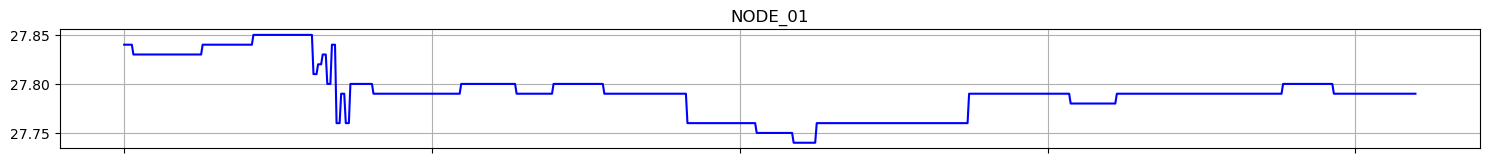

In [18]:
# Define colors for each feature for visibility
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'black']
n_features = 7
plt.figure(figsize=(15, 10))

# Plot each feature with specified color and share the x-axis
for i, (feature, color) in enumerate(zip(five_weeks_data.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)  # Share the x-axis
    five_weeks_data[feature].plot(ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.grid(True)

    # Only show the x-axis label on the last subplot
    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

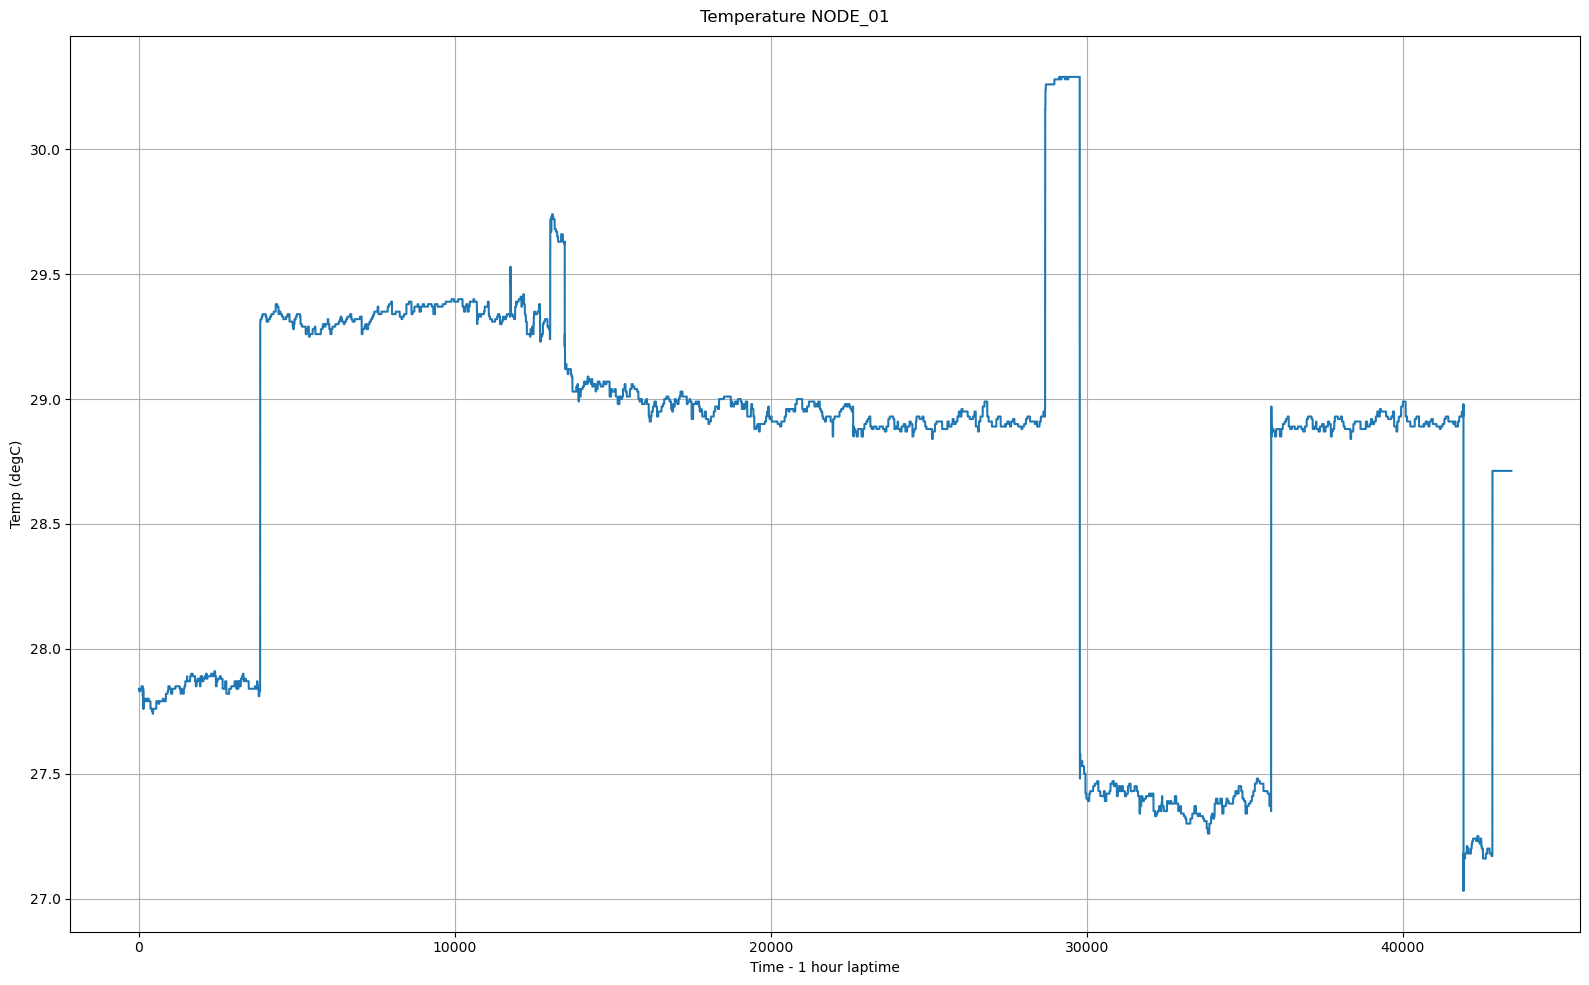

In [19]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.set_xlabel('Time - 1 hour laptime')
ax1.set_ylabel('Temp (degC)')
ax1.plot(data_selected['NODE_01'], linestyle='-')
ax1.tick_params(axis='y')

# Optional: Add a title and adjust layout
plt.suptitle('Temperature NODE_01')
plt.grid()
fig.tight_layout()  # adjust subplot parameters to give specified padding

plt.show()

## Splitting the dataset into training, validation, and testing sets

In [21]:
SPLIT = 0.8

In [22]:
train_size = int(len(data_selected) * SPLIT)
val_size = int(len(data_selected) * (1-SPLIT)//2)
test_size = len(data_selected) - train_size - val_size

data_train = data_selected[:train_size]
data_val = data_selected[train_size:train_size + val_size]
data_test = data_selected[-test_size:]


data_train.shape, data_val.shape, data_test.shape

((34747, 1), (4343, 1), (4344, 1))

In [23]:
train_size, val_size, test_size

(34747, 4343, 4344)

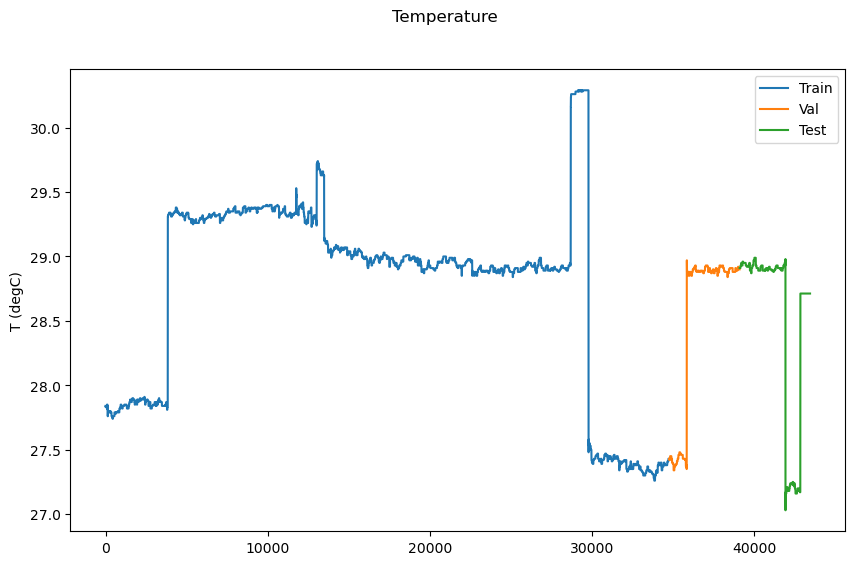

In [24]:
plt.figure(figsize=(10, 6))
data_train['NODE_01'].plot(legend=True)
data_val['NODE_01'].plot(legend=True)
data_test['NODE_01'].plot(legend=True)
plt.legend(['Train', 'Val', 'Test']);
plt.suptitle('Temperature')
plt.ylabel('T (degC)');

## Normalize the data

NOTE:
- The fit method should only be called on the training data, and then the transform method is used on the training, validation and test data.
- Never fit the scaler on the test data or any data used for predictions, as it can introduce future information into the model (a form of data leakage), resulting in over-optimistic performance estimates.
- Save the scaler object along with the model, so we can use the model for future predictions, ensuring we can apply the same scaling to new data.

In [27]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_normalized = scaler.fit_transform(data_train)
data_val_normalized = scaler.transform(data_val)
data_test_normalized = scaler.transform(data_test)



### Save the scaler parameters to a Text file

In [29]:
# Save the scaler parameters to a text file
with open('scaler_params.txt', 'w') as file:
    file.write('scale:' + ','.join(map(str, scaler.scale_)) + '\n')
    file.write('min:' + ','.join(map(str, scaler.min_)) + '\n')
    file.write('data_min:' + ','.join(map(str, scaler.data_min_)) + '\n')
    file.write('data_max:' + ','.join(map(str, scaler.data_max_)) + '\n')
    file.write('data_range:' + ','.join(map(str, scaler.data_range_)) + '\n')

In [30]:
print(f'Train: {data_train_normalized.min()}, {data_train_normalized.max()}')
print(f'Test:  {data_test_normalized.min()}, {data_test_normalized.max()}')
print(f'Val:   {data_val_normalized.min()}, {data_val_normalized.max()}')

Train: 0.0, 1.0
Test:  -0.07590759075907627, 0.5709570957095718
Val:   0.026402640264025834, 0.564356435643564


## Create Features
- Prediction will be Temperature

In [32]:
def create_sequences(input_data, n_steps, fut_hours, out_feat_index):
    X, y = [], []
    for i in range(len(input_data) - n_steps - fut_hours):
        # Define the end of the input sequence
        end_ix = i + n_steps
        # Define the end of the output sequence
        out_end_ix = end_ix + fut_hours
        # Ensure we have enough data for this instance
        if out_end_ix > len(input_data):
            break
        # Retrieve input and output
        seq_x, seq_y = input_data[i:end_ix, :], input_data[out_end_ix - 1, out_feat_index]  # i.e. 0 is the index for 'tempC'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [33]:
# Creating sequences (using 168 timesteps, which is 1 weekm 7x24)
output_feature = 'NODE_01'
out_feat_index = numeric_cols.index(output_feature)
fut_hours = 1
n_steps = 20
n_inputs = len(data_selected.columns)

In [34]:
X_train, y_train = create_sequences(data_train_normalized, n_steps, fut_hours, out_feat_index)
X_val, y_val = create_sequences(data_val_normalized, n_steps, fut_hours, out_feat_index)
X_test, y_test = create_sequences(data_test_normalized, n_steps, fut_hours, out_feat_index)

In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(34726, 20, 1) (34726,)
(4323, 20, 1) (4323,)
(4322, 20, 1) (4322,)


## Design Model

In [38]:
# Building the LSTM model
model = Sequential([
    LSTM(128,
         input_shape=(n_steps, X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [40]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True)

In [41]:
# Define your batch size and EPOCHS
BATCH = 30
EPOCHS = 20

In [42]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0065 - val_loss: 2.5198e-04
Epoch 2/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.9241e-04 - val_loss: 1.7896e-04
Epoch 3/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1892e-04 - val_loss: 1.4865e-04
Epoch 4/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 9.1510e-05 - val_loss: 6.3686e-04
Epoch 5/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.8088e-05 - val_loss: 1.1304e-04
Epoch 6/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 9.5800e-05 - val_loss: 9.8658e-05
Epoch 7/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.3091e-05 - val_loss: 8.4323e-05
Epoch 8/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 2.5542e-05 - val_loss: 7.7807e-05
Epoch 9/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.5734e-05 - val_loss: 7.4431e-05
Epoch 10/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.2813e-04 - val_loss: 7.2104e-05
Epoch 11/20
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 

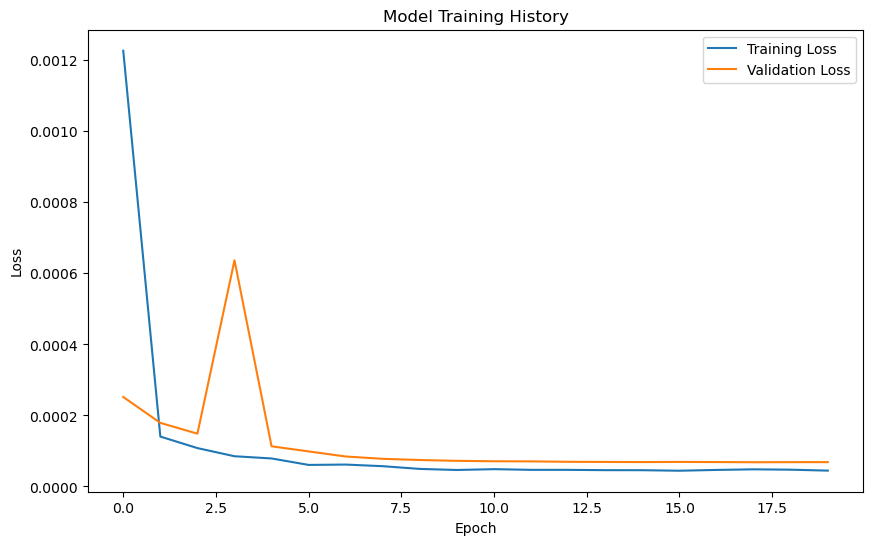

In [43]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [44]:
from math import sqrt
err = model.evaluate(X_test, y_test)
print(f'  RMSE test:\t {sqrt(err):.3f}')

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4394e-05
  RMSE test:	 0.013


In [45]:
prediccion = model.predict(X_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [46]:
prediccion

array([[0.5443789 ],
       [0.5443789 ],
       [0.5443789 ],
       ...,
       [0.47905704],
       [0.47905704],
       [0.47905704]], dtype=float32)

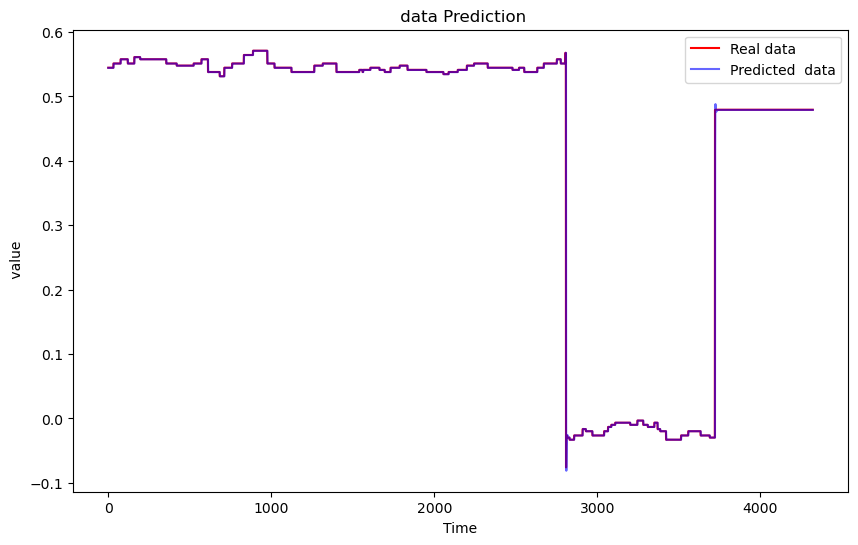

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(prediccion, color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

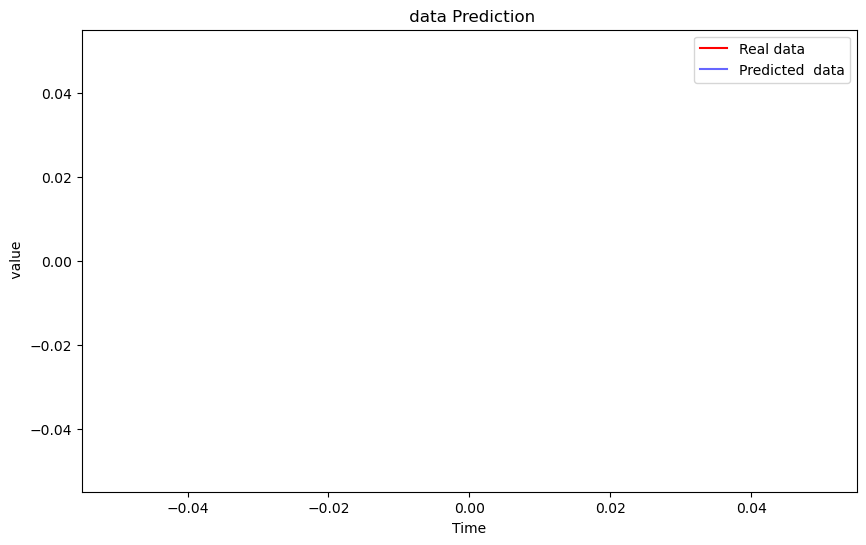

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[12000:], color = 'red', label = 'Real data')
plt.plot(prediccion[12000:], color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

## Create TFLite LSTM Model - Float32

- EI does support LSTM since tflite micro update last year, but it comes with a few limitations, most importantly, the converted tflite model should have **UnidirectionalLSTM** operator
- Float32 is supported and tested, while quantized model does not seem to work (even with full tflite)

In [65]:
run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = n_inputs
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "lstm"
# Salva il modello
model.export('lstm')

converter = tf.lite.TFLiteConverter.from_saved_model('lstm')

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the converted model to file
tflite_model_file = 'lstm.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


Saved artifact at 'lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  6116994960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6116995536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6116996304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6116996496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6116996112: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1727356631.236652  426737 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1727356631.236665  426737 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-09-26 15:17:11.236756: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: lstm
2024-09-26 15:17:11.237116: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-09-26 15:17:11.237121: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: lstm
2024-09-26 15:17:11.241511: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-09-26 15:17:11.253178: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: lstm
2024-09-26 15:17:11.258365: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 21609 microseconds.
2024-09-26 15:17:11.283442: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:

In [67]:
import numpy as np
import tensorflow as tf

# Carica il modello convertito
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Ottieni i dettagli delle tensioni di input e output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Crea un input dummy per testare il modello
dummy_input = np.random.rand(BATCH_SIZE, STEPS, INPUT_SIZE).astype(input_details[0]['dtype'])

# Esegui l'inferenza
interpreter.set_tensor(input_details[0]['index'], dummy_input)
interpreter.invoke()

# Ottieni l'output
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[0.90881336]]


2024-09-26 15:17:13.848618: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_inter_op_parallelism which is not in the op definition: Op<name=TensorListReserve; signature=element_shape:shape_type, num_elements:int32 -> handle:variant; attr=element_dtype:type; attr=shape_type:type,allowed=[DT_INT32, DT_INT64]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node TensorListReserve}}


In [52]:
# Initialize the TFLite interpreter
interp = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
interp.allocate_tensors()

# Get input/output layer information
i_details = interp.get_input_details()[0]
o_details = interp.get_output_details()[0]

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 10 nodes with 2 partitions.

2024-09-26 15:04:10.148994: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_inter_op_parallelism which is not in the op definition: Op<name=TensorListReserve; signature=element_shape:shape_type, num_elements:int32 -> handle:variant; attr=element_dtype:type; attr=shape_type:type,allowed=[DT_INT32, DT_INT64]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node TensorListReserve}}
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [53]:
i_details

{'name': 'serving_default_keras_tensor:0',
 'index': 0,
 'shape': array([ 1, 20,  1], dtype=int32),
 'shape_signature': array([-1, 20,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [54]:
o_details

{'name': 'StatefulPartitionedCall_1:0',
 'index': 29,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([-1,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

## Deploy LSTM Float32 Model (Unidirecional operator)

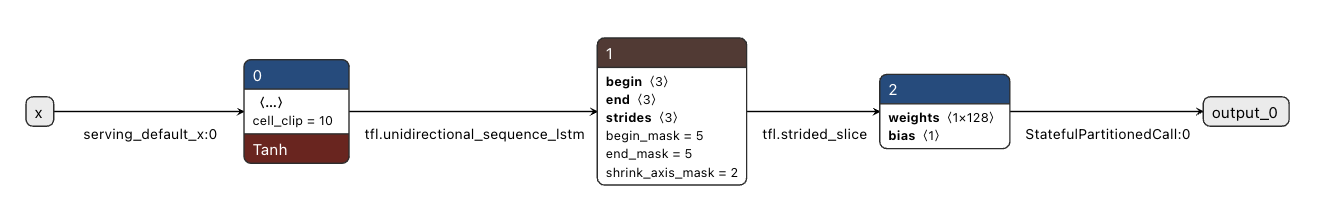

### Install the Python SDK library:

In [58]:
!python -m pip install edgeimpulse

In [60]:
ei.API_KEY = "Your Key" # Change to your key

NameError: name 'ei' is not defined

In [ ]:
# Estimate the RAM, ROM, and inference time for our model on the target hardware family
try:
    profile = ei.model.profile(model=tflite_model,
                               device='espressif-esp32')
    print(profile.summary())
except Exception as e:
    print(f"Could not profile: {e}")

In [ ]:
download_dir = "./"
deploy_filename = "lstm_float32_model.zip"

In [ ]:
# Create an Arduino library with trained model
deploy_bytes = None
try:
    deploy_bytes = ei.model.deploy(tflite_model,
                                   model_output_type=ei.model.output_type.Regression(),
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")

# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

## Generate test datapoint for inference

In [ ]:
y_test[0]

In [ ]:
X_test[0].shape

In [ ]:
reshaped_test = X_test[0].reshape(-1)
reshaped_test.shape

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
reshaped_test

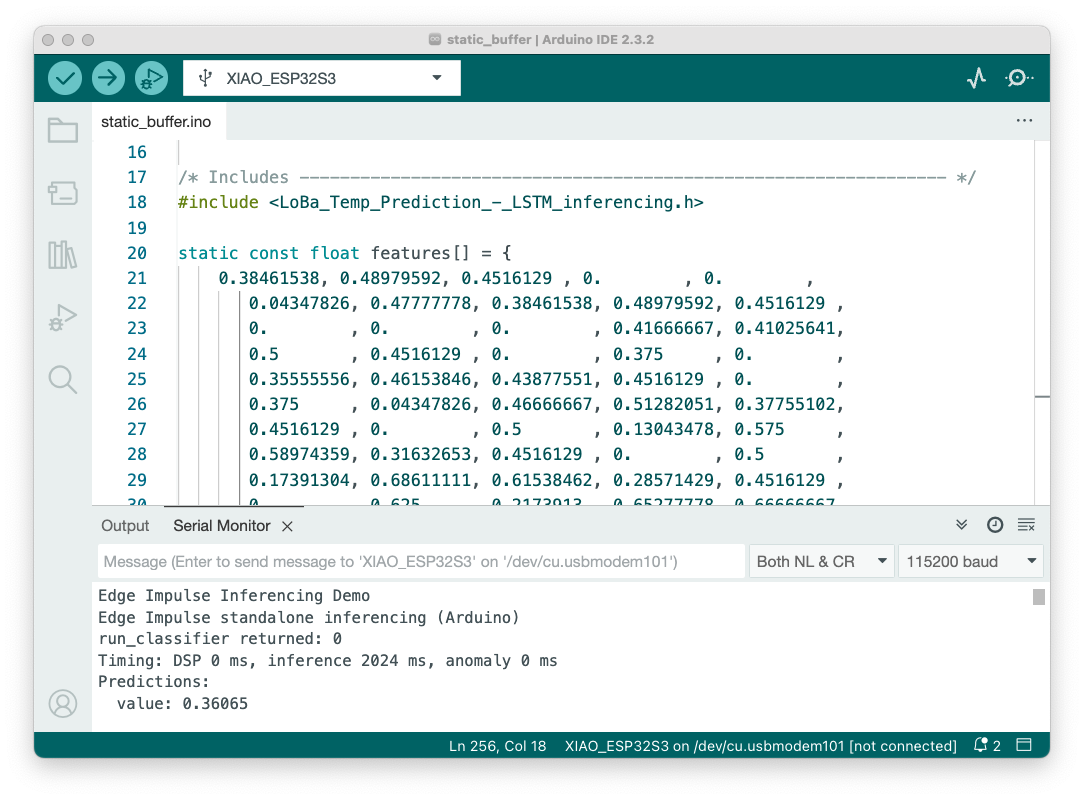

### Rescaling inference result to real temperaure

To load these parameters back into a MinMaxScaler instance:

In [ ]:
# Load the scaler parameters from the text file
loaded_scaler_params = {}
with open('scaler_params.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        loaded_scaler_params[key] = np.array([float(i) for i in value.split(',')])

# Create a new scaler instance and set its parameters
inference_scaler = MinMaxScaler()
inference_scaler.scale_ = loaded_scaler_params['scale']
inference_scaler.min_ = loaded_scaler_params['min']
inference_scaler.data_min_ = loaded_scaler_params['data_min']
inference_scaler.data_max_ = loaded_scaler_params['data_max']
inference_scaler.data_range_ = loaded_scaler_params['data_range']

In [ ]:
inference_scaler.data_min_.shape

In [ ]:
data_min = inference_scaler.data_min_[0]
data_min

In [ ]:
data_max = inference_scaler.data_max_[0]
data_max

In [ ]:
value = 0.36065
temp = value * (data_max - data_min) + data_min
temp